In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork

from args import *
from utils import *

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

In [3]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()

in_dim = train_dataset[0].x.shape[-1]
model = GCNNetwork(in_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=args["sche_mode"], factor=args["sche_factor"], patience=args["sche_patience"], min_lr=args["sche_min_lr"])

25092 8364 8363


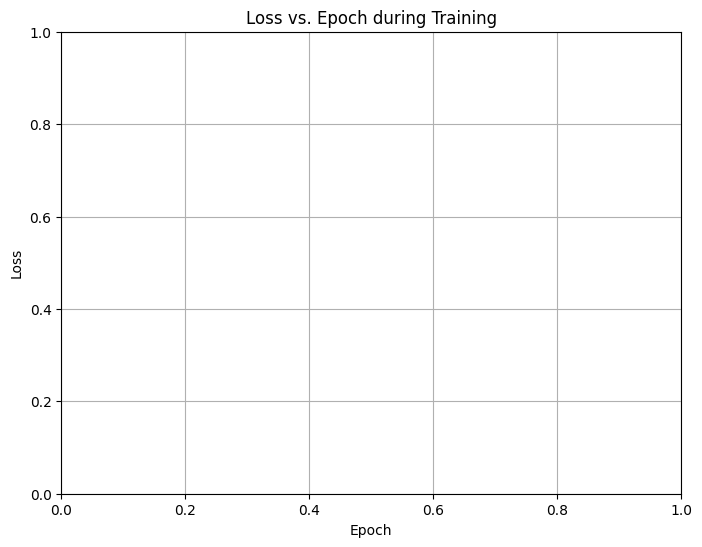

In [4]:
epochs = args["epochs"]

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

In [ ]:
import copy
# copy.deepcopy()

best_test

def save_model_GCN(model, res_path,model_filename="model.pt"):
    model_filename = osp.join(res_path, model_filename)
    torch.save(model, model_filename)


Epoch 1, training loss(MAE)=0.1732, validating loss(MAE)=0.072, testing loss(MAE)=0.073, lr=0.01
Epoch 2, training loss(MAE)=0.0652, validating loss(MAE)=0.0999, testing loss(MAE)=0.0996, lr=0.01
Epoch 3, training loss(MAE)=0.0528, validating loss(MAE)=0.1255, testing loss(MAE)=0.126, lr=0.01
Epoch 4, training loss(MAE)=0.0467, validating loss(MAE)=0.0732, testing loss(MAE)=0.0732, lr=0.01


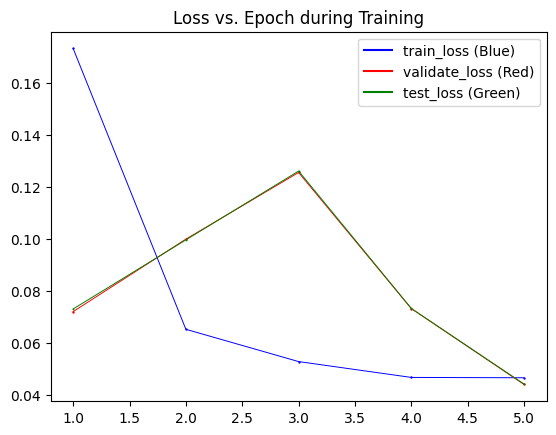

Epoch 5, training loss(MAE)=0.0466, validating loss(MAE)=0.044, testing loss(MAE)=0.0441, lr=0.01
Epoch 6, training loss(MAE)=0.0447, validating loss(MAE)=0.0516, testing loss(MAE)=0.052, lr=0.01
Epoch 7, training loss(MAE)=0.0447, validating loss(MAE)=0.0416, testing loss(MAE)=0.0419, lr=0.01
Epoch 8, training loss(MAE)=0.0411, validating loss(MAE)=0.0419, testing loss(MAE)=0.0419, lr=0.01
Epoch 9, training loss(MAE)=0.0392, validating loss(MAE)=0.0455, testing loss(MAE)=0.0458, lr=0.01


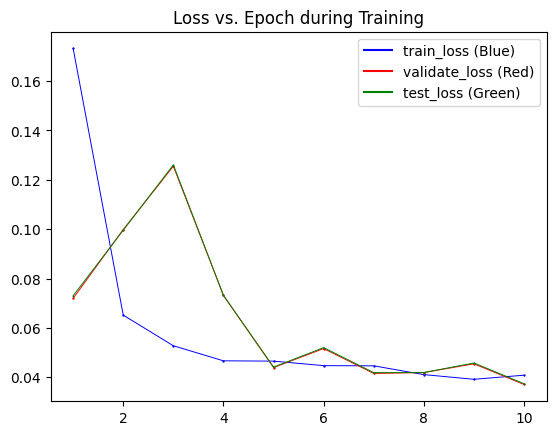

Epoch 10, training loss(MAE)=0.0409, validating loss(MAE)=0.0371, testing loss(MAE)=0.0374, lr=0.01
Epoch 11, training loss(MAE)=0.039, validating loss(MAE)=0.0491, testing loss(MAE)=0.0489, lr=0.01
Epoch 12, training loss(MAE)=0.0394, validating loss(MAE)=0.0415, testing loss(MAE)=0.042, lr=0.01
Epoch 13, training loss(MAE)=0.041, validating loss(MAE)=0.054, testing loss(MAE)=0.0541, lr=0.01
Epoch 14, training loss(MAE)=0.0431, validating loss(MAE)=0.0363, testing loss(MAE)=0.0364, lr=0.01


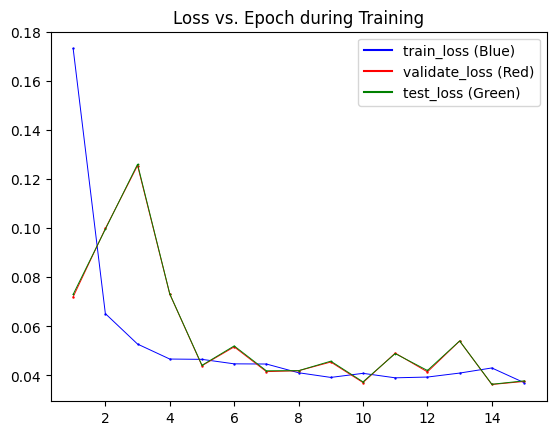

Epoch 15, training loss(MAE)=0.0371, validating loss(MAE)=0.0376, testing loss(MAE)=0.0378, lr=0.01
Epoch 16, training loss(MAE)=0.0369, validating loss(MAE)=0.0402, testing loss(MAE)=0.0408, lr=0.01
Epoch 17, training loss(MAE)=0.0395, validating loss(MAE)=0.0345, testing loss(MAE)=0.0348, lr=0.01
Epoch 18, training loss(MAE)=0.0366, validating loss(MAE)=0.0365, testing loss(MAE)=0.0368, lr=0.01
Epoch 19, training loss(MAE)=0.0363, validating loss(MAE)=0.0479, testing loss(MAE)=0.0483, lr=0.01


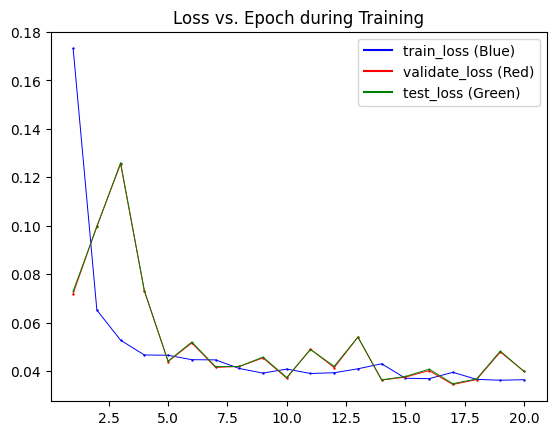

Epoch 20, training loss(MAE)=0.0365, validating loss(MAE)=0.0399, testing loss(MAE)=0.0399, lr=0.01
Epoch 21, training loss(MAE)=0.0365, validating loss(MAE)=0.0327, testing loss(MAE)=0.0325, lr=0.01
Epoch 22, training loss(MAE)=0.0354, validating loss(MAE)=0.0324, testing loss(MAE)=0.0325, lr=0.01
Epoch 23, training loss(MAE)=0.0349, validating loss(MAE)=0.0579, testing loss(MAE)=0.0581, lr=0.01
Epoch 24, training loss(MAE)=0.0358, validating loss(MAE)=0.0315, testing loss(MAE)=0.0316, lr=0.01


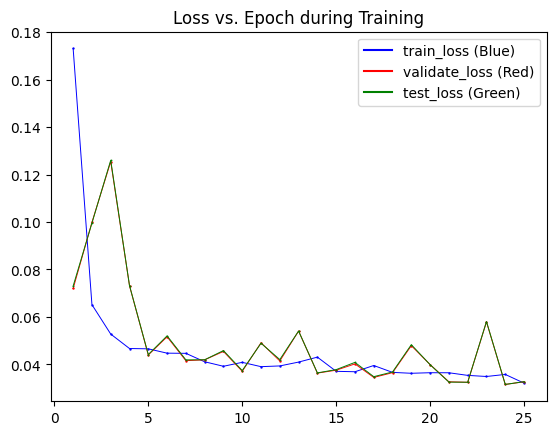

Epoch 25, training loss(MAE)=0.0321, validating loss(MAE)=0.0327, testing loss(MAE)=0.0327, lr=0.01
Epoch 26, training loss(MAE)=0.0317, validating loss(MAE)=0.032, testing loss(MAE)=0.032, lr=0.01
Epoch 27, training loss(MAE)=0.0322, validating loss(MAE)=0.0391, testing loss(MAE)=0.0387, lr=0.01
Epoch 28, training loss(MAE)=0.0317, validating loss(MAE)=0.048, testing loss(MAE)=0.0483, lr=0.01
Epoch 29, training loss(MAE)=0.0346, validating loss(MAE)=0.0561, testing loss(MAE)=0.0555, lr=0.01


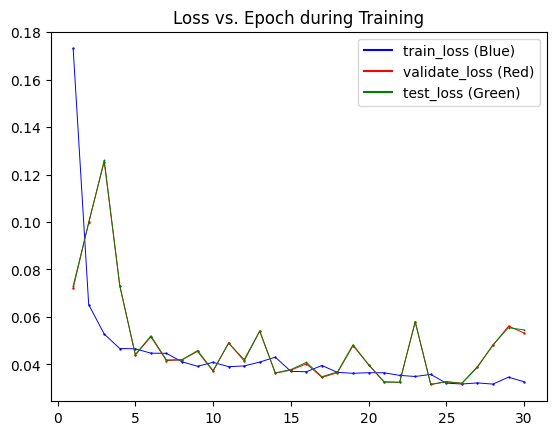

Epoch 30, training loss(MAE)=0.0327, validating loss(MAE)=0.0532, testing loss(MAE)=0.0545, lr=0.01
Epoch 31, training loss(MAE)=0.0471, validating loss(MAE)=0.0556, testing loss(MAE)=0.0557, lr=0.01
Epoch 32, training loss(MAE)=0.0361, validating loss(MAE)=0.045, testing loss(MAE)=0.0449, lr=0.01
Epoch 33, training loss(MAE)=0.035, validating loss(MAE)=0.0454, testing loss(MAE)=0.0452, lr=0.01
Epoch 34, training loss(MAE)=0.0359, validating loss(MAE)=0.0392, testing loss(MAE)=0.04, lr=0.01


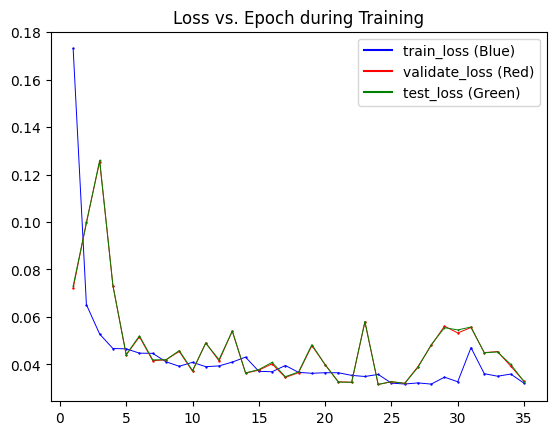

Epoch 35, training loss(MAE)=0.0321, validating loss(MAE)=0.0329, testing loss(MAE)=0.0327, lr=0.005
Epoch 36, training loss(MAE)=0.0323, validating loss(MAE)=0.0301, testing loss(MAE)=0.0302, lr=0.005
Epoch 37, training loss(MAE)=0.0307, validating loss(MAE)=0.0306, testing loss(MAE)=0.0305, lr=0.005
Epoch 38, training loss(MAE)=0.0301, validating loss(MAE)=0.0289, testing loss(MAE)=0.0289, lr=0.005
Epoch 39, training loss(MAE)=0.0311, validating loss(MAE)=0.0323, testing loss(MAE)=0.0319, lr=0.005


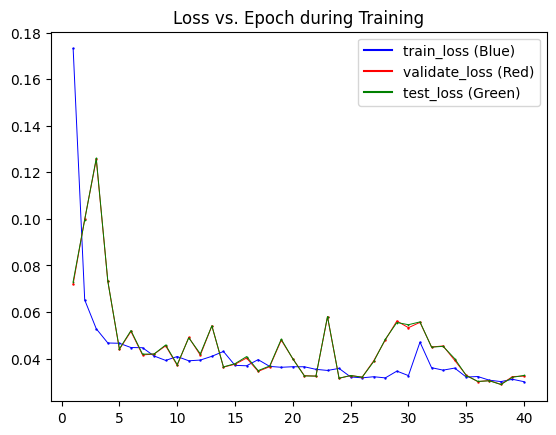

Epoch 40, training loss(MAE)=0.0301, validating loss(MAE)=0.0325, testing loss(MAE)=0.0328, lr=0.005
Epoch 41, training loss(MAE)=0.0302, validating loss(MAE)=0.0289, testing loss(MAE)=0.0289, lr=0.005
Epoch 42, training loss(MAE)=0.0314, validating loss(MAE)=0.0293, testing loss(MAE)=0.0294, lr=0.005
Epoch 43, training loss(MAE)=0.0313, validating loss(MAE)=0.0292, testing loss(MAE)=0.0292, lr=0.005
Epoch 44, training loss(MAE)=0.0296, validating loss(MAE)=0.0432, testing loss(MAE)=0.044, lr=0.005


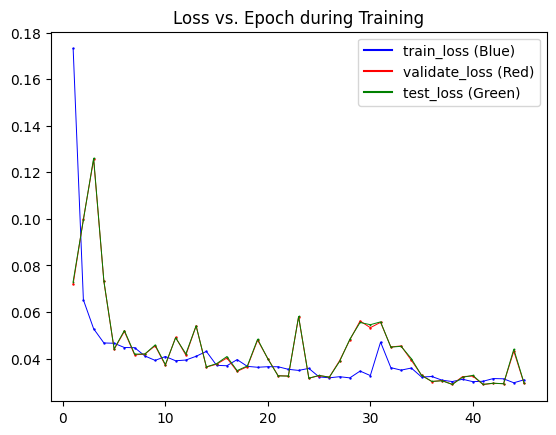

Epoch 45, training loss(MAE)=0.0309, validating loss(MAE)=0.0293, testing loss(MAE)=0.0295, lr=0.005
Epoch 46, training loss(MAE)=0.03, validating loss(MAE)=0.0279, testing loss(MAE)=0.028, lr=0.005
Epoch 47, training loss(MAE)=0.03, validating loss(MAE)=0.0352, testing loss(MAE)=0.0358, lr=0.005
Epoch 48, training loss(MAE)=0.031, validating loss(MAE)=0.0297, testing loss(MAE)=0.0297, lr=0.005
Epoch 49, training loss(MAE)=0.0305, validating loss(MAE)=0.0289, testing loss(MAE)=0.0289, lr=0.005


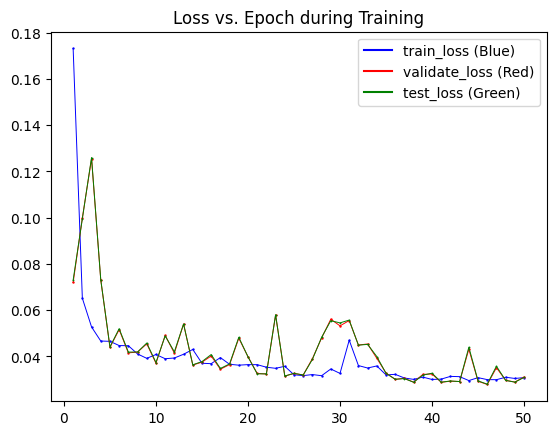

Epoch 50, training loss(MAE)=0.0309, validating loss(MAE)=0.0311, testing loss(MAE)=0.0309, lr=0.005
Epoch 51, training loss(MAE)=0.0307, validating loss(MAE)=0.0297, testing loss(MAE)=0.0297, lr=0.005
Epoch 52, training loss(MAE)=0.0302, validating loss(MAE)=0.0296, testing loss(MAE)=0.0295, lr=0.005
Epoch 53, training loss(MAE)=0.0299, validating loss(MAE)=0.0292, testing loss(MAE)=0.0293, lr=0.005
Epoch 54, training loss(MAE)=0.0297, validating loss(MAE)=0.0284, testing loss(MAE)=0.0287, lr=0.005


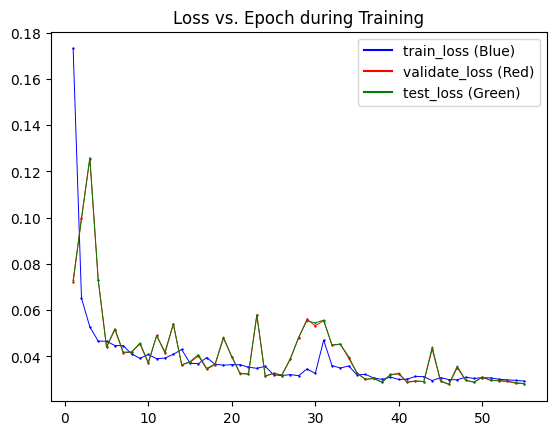

Epoch 55, training loss(MAE)=0.0294, validating loss(MAE)=0.0282, testing loss(MAE)=0.0283, lr=0.005
Epoch 56, training loss(MAE)=0.0304, validating loss(MAE)=0.0328, testing loss(MAE)=0.0325, lr=0.005
Epoch 57, training loss(MAE)=0.0293, validating loss(MAE)=0.033, testing loss(MAE)=0.0331, lr=0.0025
Epoch 58, training loss(MAE)=0.029, validating loss(MAE)=0.0287, testing loss(MAE)=0.0288, lr=0.0025
Epoch 59, training loss(MAE)=0.0299, validating loss(MAE)=0.0293, testing loss(MAE)=0.0291, lr=0.0025


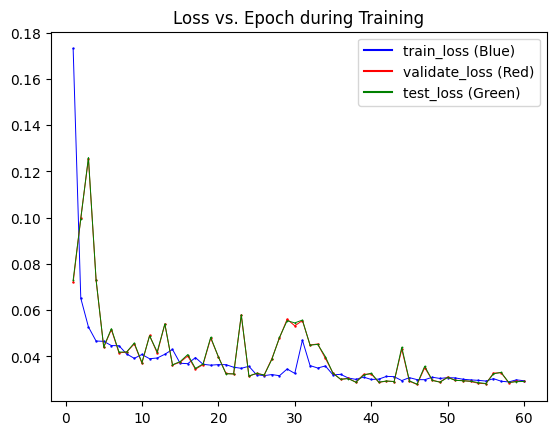

Epoch 60, training loss(MAE)=0.0295, validating loss(MAE)=0.0292, testing loss(MAE)=0.0292, lr=0.0025
Epoch 61, training loss(MAE)=0.0287, validating loss(MAE)=0.0298, testing loss(MAE)=0.0296, lr=0.0025
Epoch 62, training loss(MAE)=0.0291, validating loss(MAE)=0.0285, testing loss(MAE)=0.0283, lr=0.0025
Epoch 63, training loss(MAE)=0.0287, validating loss(MAE)=0.0275, testing loss(MAE)=0.0274, lr=0.0025
Epoch 64, training loss(MAE)=0.0282, validating loss(MAE)=0.0344, testing loss(MAE)=0.0343, lr=0.0025


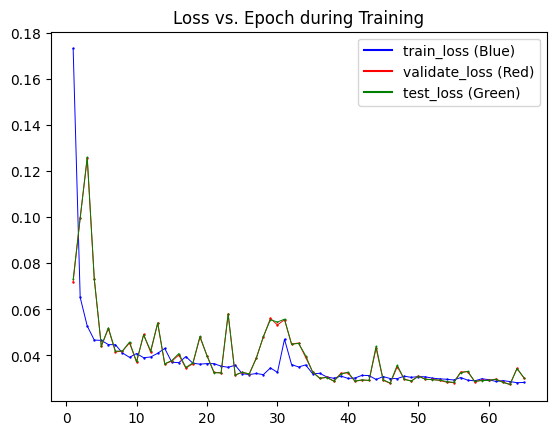

Epoch 65, training loss(MAE)=0.0283, validating loss(MAE)=0.0302, testing loss(MAE)=0.0303, lr=0.0025
Epoch 66, training loss(MAE)=0.0288, validating loss(MAE)=0.0295, testing loss(MAE)=0.0293, lr=0.0025
Epoch 67, training loss(MAE)=0.0285, validating loss(MAE)=0.0275, testing loss(MAE)=0.0276, lr=0.0025
Epoch 68, training loss(MAE)=0.0284, validating loss(MAE)=0.0272, testing loss(MAE)=0.0273, lr=0.0025
Epoch 69, training loss(MAE)=0.0284, validating loss(MAE)=0.0305, testing loss(MAE)=0.0307, lr=0.0025


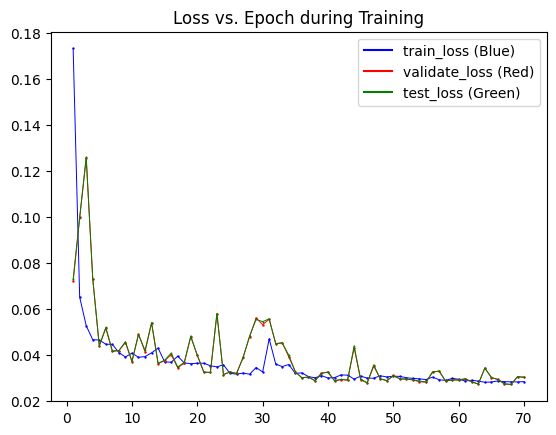

Epoch 70, training loss(MAE)=0.0285, validating loss(MAE)=0.0305, testing loss(MAE)=0.0303, lr=0.0025
Epoch 71, training loss(MAE)=0.0284, validating loss(MAE)=0.0292, testing loss(MAE)=0.0292, lr=0.0025
Epoch 72, training loss(MAE)=0.0286, validating loss(MAE)=0.0269, testing loss(MAE)=0.0269, lr=0.0025
Epoch 73, training loss(MAE)=0.0282, validating loss(MAE)=0.0277, testing loss(MAE)=0.0279, lr=0.0025
Epoch 74, training loss(MAE)=0.0283, validating loss(MAE)=0.0302, testing loss(MAE)=0.0306, lr=0.0025


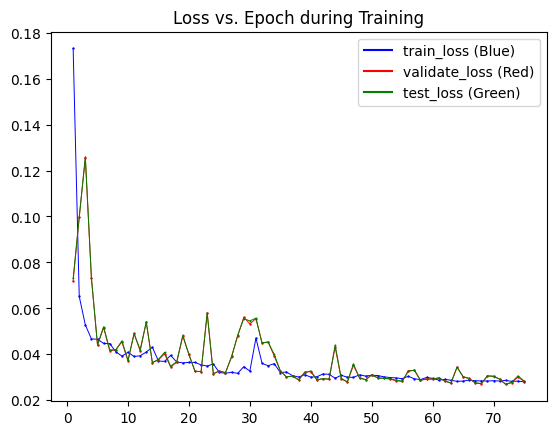

Epoch 75, training loss(MAE)=0.028, validating loss(MAE)=0.0282, testing loss(MAE)=0.0284, lr=0.0025
Epoch 76, training loss(MAE)=0.0281, validating loss(MAE)=0.0326, testing loss(MAE)=0.0331, lr=0.0025
Epoch 77, training loss(MAE)=0.029, validating loss(MAE)=0.0281, testing loss(MAE)=0.0281, lr=0.0025
Epoch 78, training loss(MAE)=0.0283, validating loss(MAE)=0.0274, testing loss(MAE)=0.0274, lr=0.0025
Epoch 79, training loss(MAE)=0.0276, validating loss(MAE)=0.0267, testing loss(MAE)=0.0267, lr=0.0025


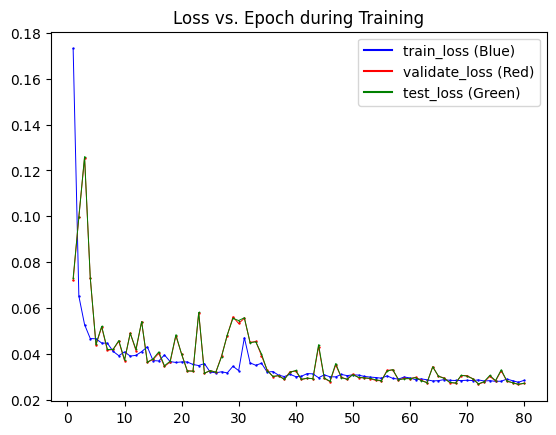

Epoch 80, training loss(MAE)=0.0285, validating loss(MAE)=0.0271, testing loss(MAE)=0.0272, lr=0.0025
Epoch 81, training loss(MAE)=0.0281, validating loss(MAE)=0.0335, testing loss(MAE)=0.034, lr=0.0025
Epoch 82, training loss(MAE)=0.0283, validating loss(MAE)=0.0384, testing loss(MAE)=0.0378, lr=0.0025
Epoch 83, training loss(MAE)=0.0289, validating loss(MAE)=0.0267, testing loss(MAE)=0.0271, lr=0.0025
Epoch 84, training loss(MAE)=0.0286, validating loss(MAE)=0.0272, testing loss(MAE)=0.0273, lr=0.0025


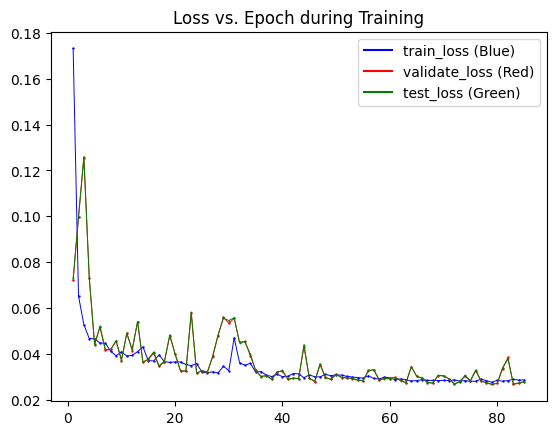

Epoch 85, training loss(MAE)=0.0286, validating loss(MAE)=0.0278, testing loss(MAE)=0.0279, lr=0.0025
Epoch 86, training loss(MAE)=0.0275, validating loss(MAE)=0.0275, testing loss(MAE)=0.0278, lr=0.0025
Epoch 87, training loss(MAE)=0.0274, validating loss(MAE)=0.0258, testing loss(MAE)=0.0261, lr=0.0025
Epoch 88, training loss(MAE)=0.0274, validating loss(MAE)=0.0278, testing loss(MAE)=0.0282, lr=0.0025
Epoch 89, training loss(MAE)=0.0279, validating loss(MAE)=0.0312, testing loss(MAE)=0.0312, lr=0.0025


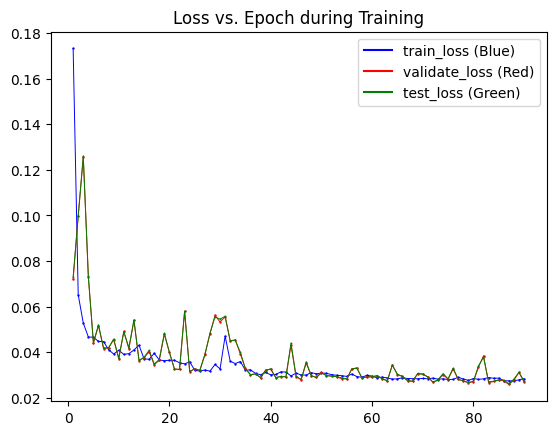

Epoch 90, training loss(MAE)=0.0284, validating loss(MAE)=0.0269, testing loss(MAE)=0.0273, lr=0.0025
Epoch 91, training loss(MAE)=0.0273, validating loss(MAE)=0.0271, testing loss(MAE)=0.0273, lr=0.0025
Epoch 92, training loss(MAE)=0.028, validating loss(MAE)=0.0264, testing loss(MAE)=0.0267, lr=0.0025
Epoch 93, training loss(MAE)=0.0274, validating loss(MAE)=0.0274, testing loss(MAE)=0.0278, lr=0.0025
Epoch 94, training loss(MAE)=0.0271, validating loss(MAE)=0.0263, testing loss(MAE)=0.0265, lr=0.0025


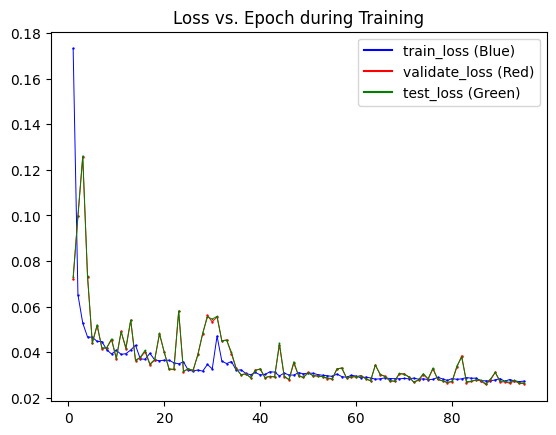

Epoch 95, training loss(MAE)=0.0273, validating loss(MAE)=0.0263, testing loss(MAE)=0.0266, lr=0.0025
Epoch 96, training loss(MAE)=0.0274, validating loss(MAE)=0.0264, testing loss(MAE)=0.0266, lr=0.0025
Epoch 97, training loss(MAE)=0.027, validating loss(MAE)=0.0292, testing loss(MAE)=0.0293, lr=0.0025
Epoch 98, training loss(MAE)=0.0283, validating loss(MAE)=0.026, testing loss(MAE)=0.0261, lr=0.00125
Epoch 99, training loss(MAE)=0.0265, validating loss(MAE)=0.027, testing loss(MAE)=0.0273, lr=0.00125


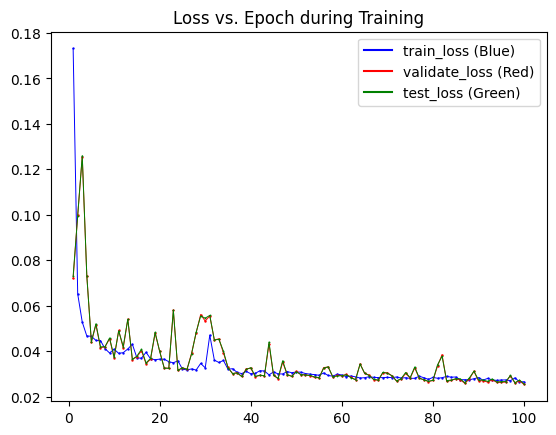

Epoch 100, training loss(MAE)=0.0265, validating loss(MAE)=0.0253, testing loss(MAE)=0.0256, lr=0.00125
Epoch 101, training loss(MAE)=0.0261, validating loss(MAE)=0.026, testing loss(MAE)=0.0264, lr=0.00125
Epoch 102, training loss(MAE)=0.0268, validating loss(MAE)=0.0264, testing loss(MAE)=0.0268, lr=0.00125
Epoch 103, training loss(MAE)=0.0262, validating loss(MAE)=0.0259, testing loss(MAE)=0.0262, lr=0.00125
Epoch 104, training loss(MAE)=0.0265, validating loss(MAE)=0.0256, testing loss(MAE)=0.0261, lr=0.00125


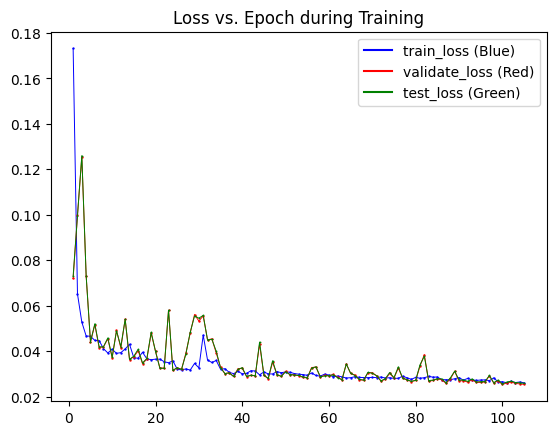

Epoch 105, training loss(MAE)=0.0261, validating loss(MAE)=0.0254, testing loss(MAE)=0.0259, lr=0.00125
Epoch 106, training loss(MAE)=0.0261, validating loss(MAE)=0.0285, testing loss(MAE)=0.0288, lr=0.00125
Epoch 107, training loss(MAE)=0.0265, validating loss(MAE)=0.0265, testing loss(MAE)=0.0268, lr=0.00125
Epoch 108, training loss(MAE)=0.0266, validating loss(MAE)=0.0265, testing loss(MAE)=0.0268, lr=0.00125
Epoch 109, training loss(MAE)=0.0267, validating loss(MAE)=0.0292, testing loss(MAE)=0.0298, lr=0.00125


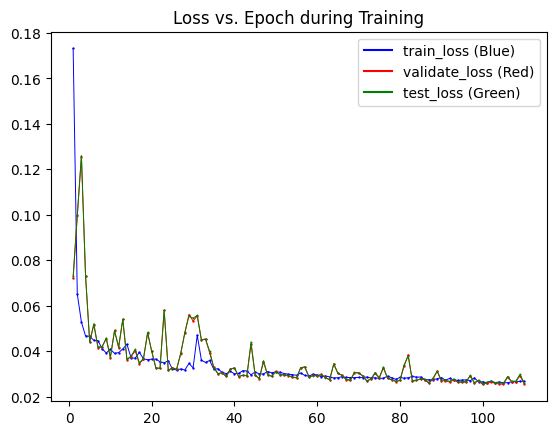

Epoch 110, training loss(MAE)=0.0268, validating loss(MAE)=0.0258, testing loss(MAE)=0.0262, lr=0.00125
Epoch 111, training loss(MAE)=0.0263, validating loss(MAE)=0.0255, testing loss(MAE)=0.0258, lr=0.000625
Epoch 112, training loss(MAE)=0.0262, validating loss(MAE)=0.026, testing loss(MAE)=0.0267, lr=0.000625
Epoch 113, training loss(MAE)=0.0259, validating loss(MAE)=0.0254, testing loss(MAE)=0.0257, lr=0.000625
Epoch 114, training loss(MAE)=0.0258, validating loss(MAE)=0.025, testing loss(MAE)=0.0254, lr=0.000625


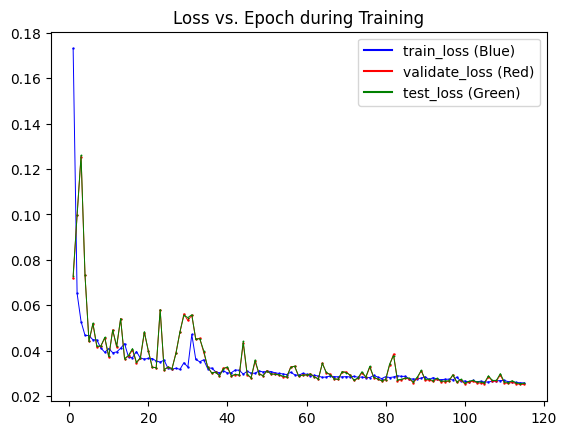

Epoch 115, training loss(MAE)=0.0257, validating loss(MAE)=0.0251, testing loss(MAE)=0.0256, lr=0.000625
Epoch 116, training loss(MAE)=0.0257, validating loss(MAE)=0.0262, testing loss(MAE)=0.0268, lr=0.000625
Epoch 117, training loss(MAE)=0.0257, validating loss(MAE)=0.0259, testing loss(MAE)=0.0265, lr=0.000625
Epoch 118, training loss(MAE)=0.0258, validating loss(MAE)=0.0256, testing loss(MAE)=0.0261, lr=0.000625
Epoch 119, training loss(MAE)=0.0258, validating loss(MAE)=0.0254, testing loss(MAE)=0.0259, lr=0.000625


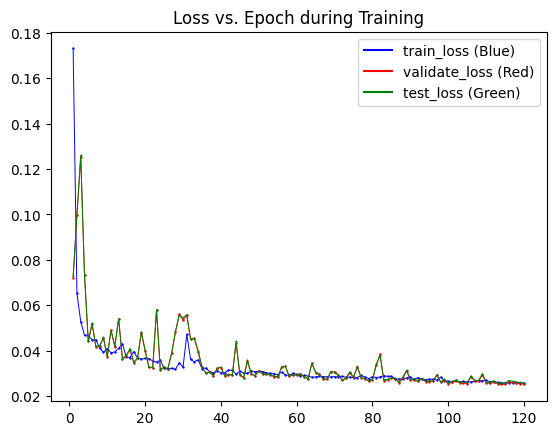

Epoch 120, training loss(MAE)=0.0256, validating loss(MAE)=0.0251, testing loss(MAE)=0.0255, lr=0.000625
Epoch 121, training loss(MAE)=0.0256, validating loss(MAE)=0.0248, testing loss(MAE)=0.0253, lr=0.000625
Epoch 122, training loss(MAE)=0.0257, validating loss(MAE)=0.0261, testing loss(MAE)=0.0265, lr=0.000625
Epoch 123, training loss(MAE)=0.0258, validating loss(MAE)=0.0251, testing loss(MAE)=0.0255, lr=0.000625
Epoch 124, training loss(MAE)=0.0264, validating loss(MAE)=0.0259, testing loss(MAE)=0.0261, lr=0.000625


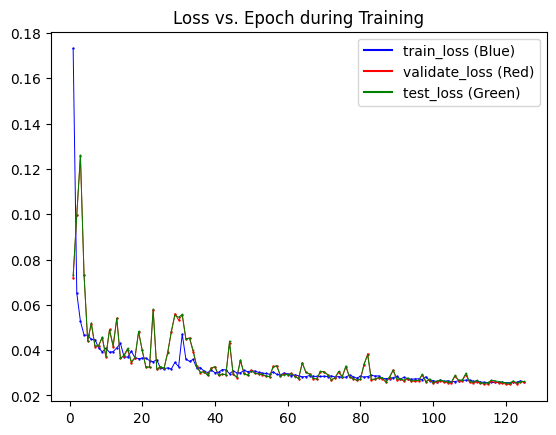

Epoch 125, training loss(MAE)=0.026, validating loss(MAE)=0.0259, testing loss(MAE)=0.0262, lr=0.000625
Epoch 126, training loss(MAE)=0.0259, validating loss(MAE)=0.0256, testing loss(MAE)=0.0259, lr=0.000625
Epoch 127, training loss(MAE)=0.0256, validating loss(MAE)=0.0264, testing loss(MAE)=0.027, lr=0.000625
Epoch 128, training loss(MAE)=0.0256, validating loss(MAE)=0.0253, testing loss(MAE)=0.0257, lr=0.000625
Epoch 129, training loss(MAE)=0.0257, validating loss(MAE)=0.0253, testing loss(MAE)=0.0257, lr=0.000625


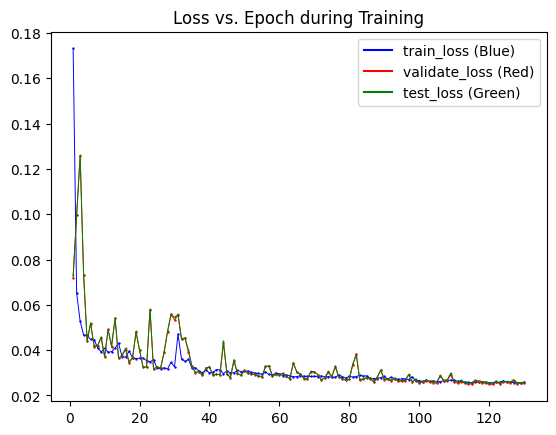

Epoch 130, training loss(MAE)=0.0258, validating loss(MAE)=0.0254, testing loss(MAE)=0.0258, lr=0.000625
Epoch 131, training loss(MAE)=0.0256, validating loss(MAE)=0.0249, testing loss(MAE)=0.0254, lr=0.000625
Epoch 132, training loss(MAE)=0.0256, validating loss(MAE)=0.025, testing loss(MAE)=0.0255, lr=0.0003125
Epoch 133, training loss(MAE)=0.0255, validating loss(MAE)=0.0249, testing loss(MAE)=0.0254, lr=0.0003125
Epoch 134, training loss(MAE)=0.0256, validating loss(MAE)=0.0258, testing loss(MAE)=0.0262, lr=0.0003125


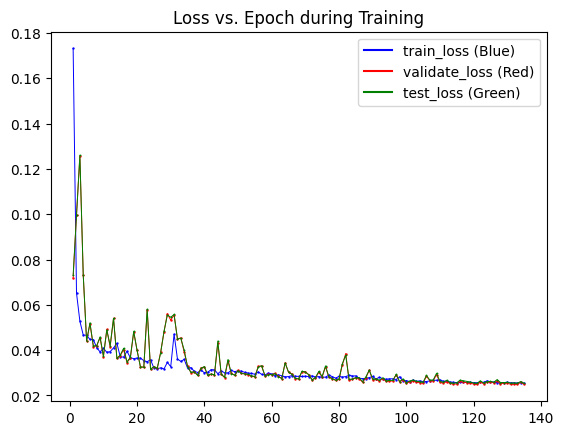

Epoch 135, training loss(MAE)=0.0255, validating loss(MAE)=0.025, testing loss(MAE)=0.0253, lr=0.0003125
Epoch 136, training loss(MAE)=0.0257, validating loss(MAE)=0.0248, testing loss(MAE)=0.0252, lr=0.0003125
Epoch 137, training loss(MAE)=0.0255, validating loss(MAE)=0.0248, testing loss(MAE)=0.0251, lr=0.0003125
Epoch 138, training loss(MAE)=0.0253, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=0.0003125
Epoch 139, training loss(MAE)=0.0254, validating loss(MAE)=0.0248, testing loss(MAE)=0.0252, lr=0.0003125


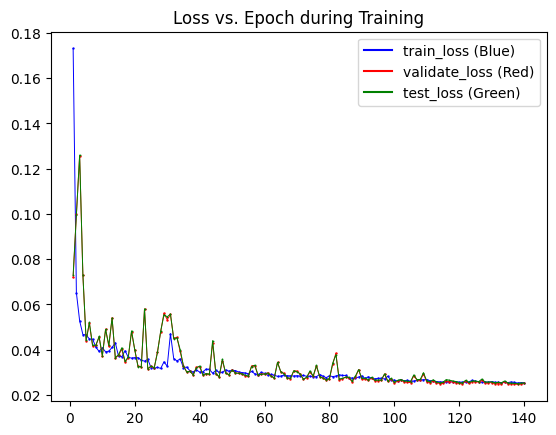

Epoch 140, training loss(MAE)=0.0254, validating loss(MAE)=0.0251, testing loss(MAE)=0.0253, lr=0.0003125
Epoch 141, training loss(MAE)=0.0253, validating loss(MAE)=0.0249, testing loss(MAE)=0.0252, lr=0.0003125
Epoch 142, training loss(MAE)=0.0255, validating loss(MAE)=0.026, testing loss(MAE)=0.0264, lr=0.0003125
Epoch 143, training loss(MAE)=0.0254, validating loss(MAE)=0.025, testing loss(MAE)=0.0254, lr=0.0003125
Epoch 144, training loss(MAE)=0.0252, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=0.0003125


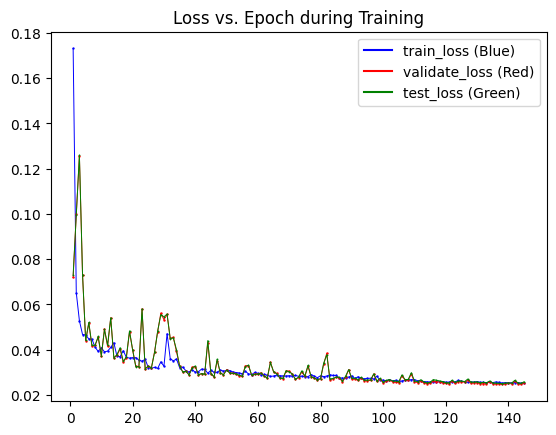

Epoch 145, training loss(MAE)=0.0251, validating loss(MAE)=0.0255, testing loss(MAE)=0.0258, lr=0.0003125
Epoch 146, training loss(MAE)=0.0253, validating loss(MAE)=0.0253, testing loss(MAE)=0.0258, lr=0.0003125
Epoch 147, training loss(MAE)=0.025, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=0.0003125
Epoch 148, training loss(MAE)=0.0251, validating loss(MAE)=0.0251, testing loss(MAE)=0.0255, lr=0.0003125
Epoch 149, training loss(MAE)=0.0253, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=0.00015625


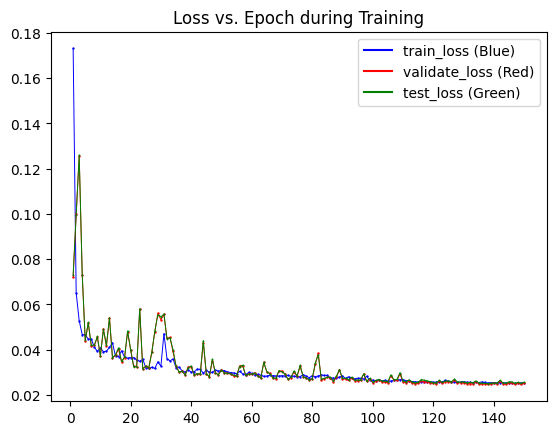

Epoch 150, training loss(MAE)=0.0254, validating loss(MAE)=0.0252, testing loss(MAE)=0.0256, lr=0.00015625
Epoch 151, training loss(MAE)=0.0251, validating loss(MAE)=0.0244, testing loss(MAE)=0.0249, lr=0.00015625
Epoch 152, training loss(MAE)=0.0251, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=0.00015625
Epoch 153, training loss(MAE)=0.0249, validating loss(MAE)=0.0251, testing loss(MAE)=0.0254, lr=0.00015625
Epoch 154, training loss(MAE)=0.0252, validating loss(MAE)=0.0245, testing loss(MAE)=0.025, lr=0.00015625


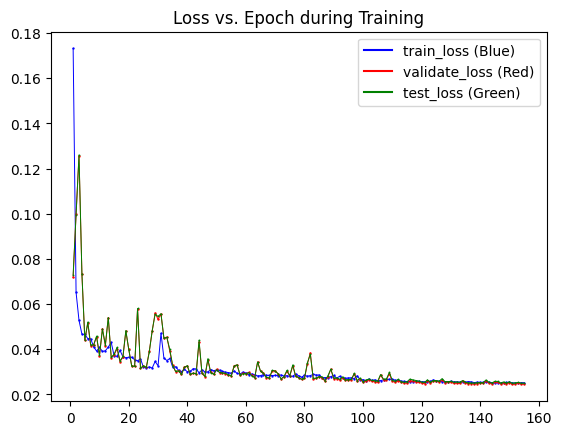

Epoch 155, training loss(MAE)=0.0252, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=0.00015625
Epoch 156, training loss(MAE)=0.0251, validating loss(MAE)=0.0249, testing loss(MAE)=0.0252, lr=0.00015625
Epoch 157, training loss(MAE)=0.0253, validating loss(MAE)=0.0246, testing loss(MAE)=0.0251, lr=0.00015625
Epoch 158, training loss(MAE)=0.0251, validating loss(MAE)=0.0258, testing loss(MAE)=0.0262, lr=0.00015625
Epoch 159, training loss(MAE)=0.025, validating loss(MAE)=0.025, testing loss(MAE)=0.0253, lr=0.00015625


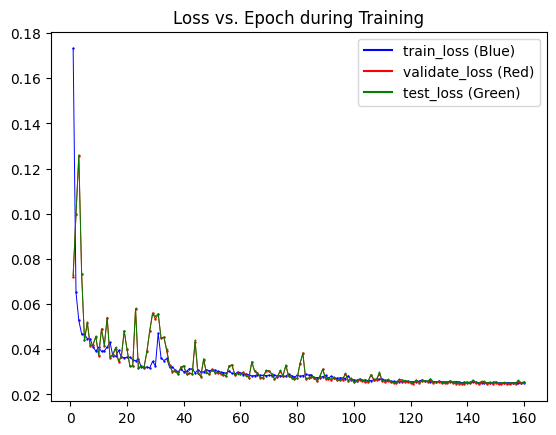

Epoch 160, training loss(MAE)=0.0252, validating loss(MAE)=0.0253, testing loss(MAE)=0.0256, lr=0.00015625
Epoch 161, training loss(MAE)=0.0251, validating loss(MAE)=0.0261, testing loss(MAE)=0.0266, lr=0.00015625
Epoch 162, training loss(MAE)=0.025, validating loss(MAE)=0.0248, testing loss(MAE)=0.0252, lr=7.813e-05
Epoch 163, training loss(MAE)=0.0249, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=7.813e-05
Epoch 164, training loss(MAE)=0.025, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=7.813e-05


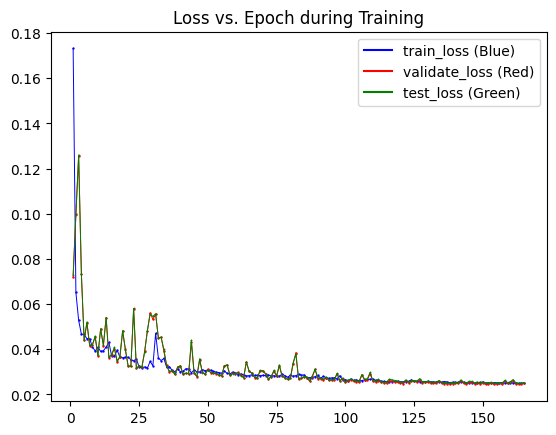

Epoch 165, training loss(MAE)=0.0251, validating loss(MAE)=0.0249, testing loss(MAE)=0.0252, lr=7.813e-05
Epoch 166, training loss(MAE)=0.0249, validating loss(MAE)=0.0269, testing loss(MAE)=0.0274, lr=7.813e-05
Epoch 167, training loss(MAE)=0.025, validating loss(MAE)=0.0252, testing loss(MAE)=0.0256, lr=7.813e-05
Epoch 168, training loss(MAE)=0.0251, validating loss(MAE)=0.0246, testing loss(MAE)=0.0251, lr=7.813e-05
Epoch 169, training loss(MAE)=0.0251, validating loss(MAE)=0.0248, testing loss(MAE)=0.0253, lr=7.813e-05


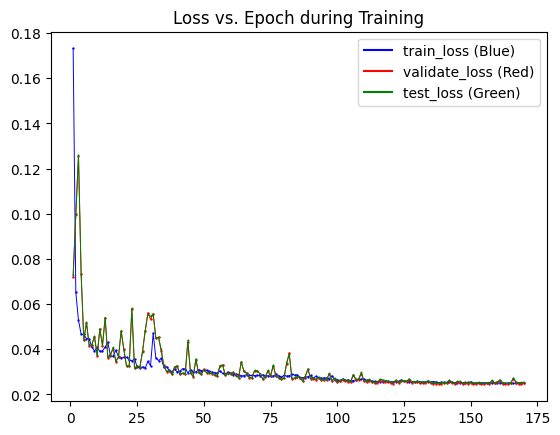

Epoch 170, training loss(MAE)=0.025, validating loss(MAE)=0.0249, testing loss(MAE)=0.0254, lr=7.813e-05
Epoch 171, training loss(MAE)=0.0249, validating loss(MAE)=0.0246, testing loss(MAE)=0.0252, lr=7.813e-05
Epoch 172, training loss(MAE)=0.0249, validating loss(MAE)=0.0254, testing loss(MAE)=0.0257, lr=7.813e-05
Epoch 173, training loss(MAE)=0.0249, validating loss(MAE)=0.0248, testing loss(MAE)=0.0252, lr=3.906e-05
Epoch 174, training loss(MAE)=0.0251, validating loss(MAE)=0.0249, testing loss(MAE)=0.0253, lr=3.906e-05


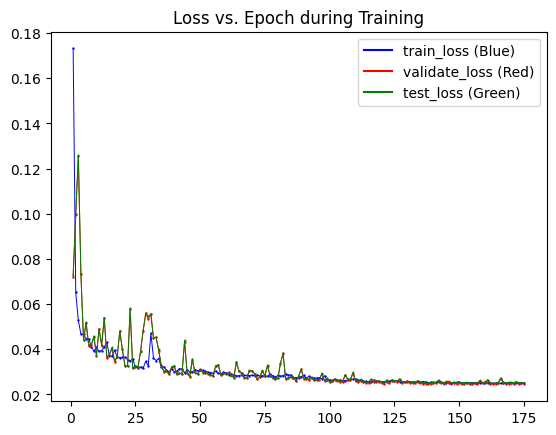

Epoch 175, training loss(MAE)=0.0251, validating loss(MAE)=0.0247, testing loss(MAE)=0.0252, lr=3.906e-05
Epoch 176, training loss(MAE)=0.0251, validating loss(MAE)=0.026, testing loss(MAE)=0.0264, lr=3.906e-05
Epoch 177, training loss(MAE)=0.025, validating loss(MAE)=0.0252, testing loss(MAE)=0.0258, lr=3.906e-05
Epoch 178, training loss(MAE)=0.0248, validating loss(MAE)=0.0248, testing loss(MAE)=0.0253, lr=3.906e-05
Epoch 179, training loss(MAE)=0.0249, validating loss(MAE)=0.0248, testing loss(MAE)=0.0253, lr=3.906e-05


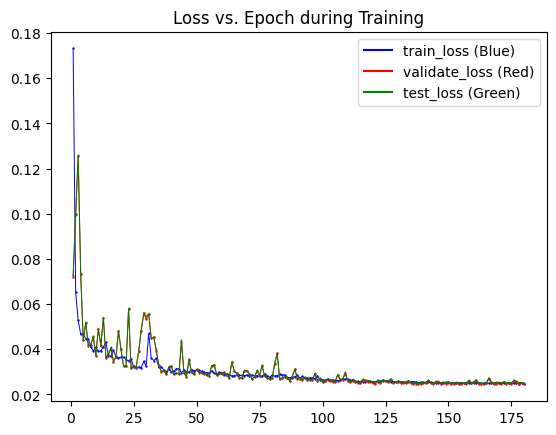

Epoch 180, training loss(MAE)=0.0248, validating loss(MAE)=0.0248, testing loss(MAE)=0.0251, lr=3.906e-05
Epoch 181, training loss(MAE)=0.0249, validating loss(MAE)=0.0245, testing loss(MAE)=0.0249, lr=3.906e-05
Epoch 182, training loss(MAE)=0.0249, validating loss(MAE)=0.0245, testing loss(MAE)=0.0249, lr=3.906e-05
Epoch 183, training loss(MAE)=0.025, validating loss(MAE)=0.0247, testing loss(MAE)=0.0253, lr=3.906e-05
Epoch 184, training loss(MAE)=0.0249, validating loss(MAE)=0.0248, testing loss(MAE)=0.0252, lr=1.953e-05


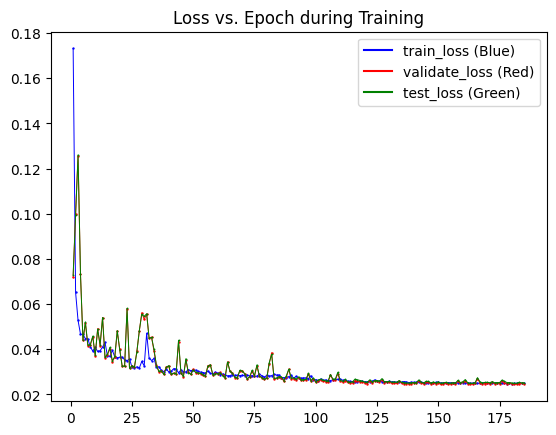

Epoch 185, training loss(MAE)=0.0249, validating loss(MAE)=0.0247, testing loss(MAE)=0.0252, lr=1.953e-05
Epoch 186, training loss(MAE)=0.0249, validating loss(MAE)=0.0245, testing loss(MAE)=0.025, lr=1.953e-05
Epoch 187, training loss(MAE)=0.0249, validating loss(MAE)=0.0252, testing loss(MAE)=0.0255, lr=1.953e-05
Epoch 188, training loss(MAE)=0.0249, validating loss(MAE)=0.0257, testing loss(MAE)=0.0263, lr=1.953e-05
Epoch 189, training loss(MAE)=0.0249, validating loss(MAE)=0.0244, testing loss(MAE)=0.0248, lr=1.953e-05


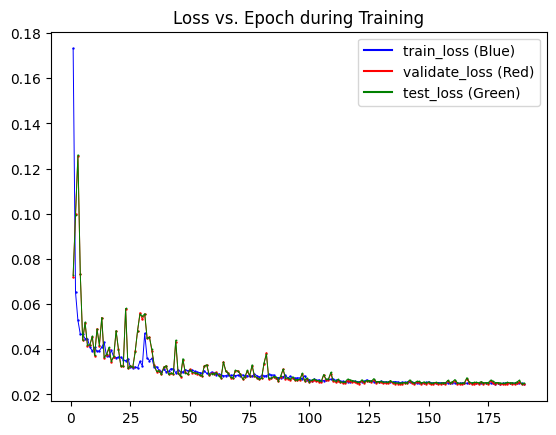

Epoch 190, training loss(MAE)=0.0248, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=1.953e-05
Epoch 191, training loss(MAE)=0.0248, validating loss(MAE)=0.0252, testing loss(MAE)=0.0256, lr=1.953e-05
Epoch 192, training loss(MAE)=0.025, validating loss(MAE)=0.025, testing loss(MAE)=0.0254, lr=1.953e-05
Epoch 193, training loss(MAE)=0.0248, validating loss(MAE)=0.0249, testing loss(MAE)=0.0255, lr=1.953e-05
Epoch 194, training loss(MAE)=0.0248, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=1.953e-05


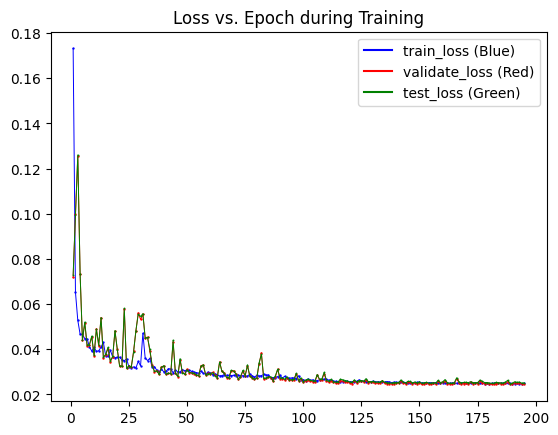

Epoch 195, training loss(MAE)=0.025, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=9.77e-06
Epoch 196, training loss(MAE)=0.0249, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=9.77e-06
Epoch 197, training loss(MAE)=0.0248, validating loss(MAE)=0.0247, testing loss(MAE)=0.0251, lr=9.77e-06
Epoch 198, training loss(MAE)=0.0247, validating loss(MAE)=0.0246, testing loss(MAE)=0.0251, lr=9.77e-06
Epoch 199, training loss(MAE)=0.025, validating loss(MAE)=0.0246, testing loss(MAE)=0.0249, lr=9.77e-06


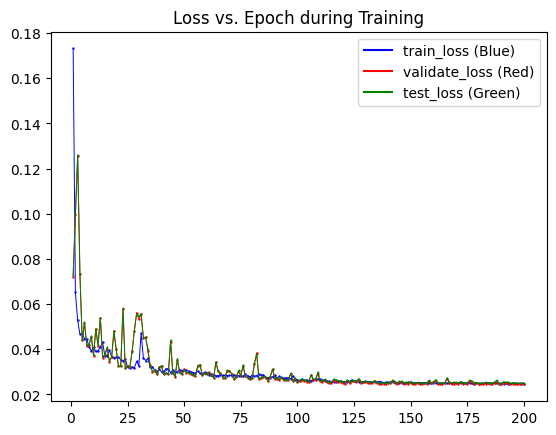

Epoch 200, training loss(MAE)=0.0248, validating loss(MAE)=0.0246, testing loss(MAE)=0.025, lr=9.77e-06
Epoch 201, training loss(MAE)=0.0248, validating loss(MAE)=0.0251, testing loss(MAE)=0.0254, lr=9.77e-06
Epoch 202, training loss(MAE)=0.0247, validating loss(MAE)=0.0244, testing loss(MAE)=0.0249, lr=9.77e-06
Epoch 203, training loss(MAE)=0.0249, validating loss(MAE)=0.0252, testing loss(MAE)=0.0257, lr=9.77e-06
Epoch 204, training loss(MAE)=0.025, validating loss(MAE)=0.0253, testing loss(MAE)=0.0258, lr=9.77e-06


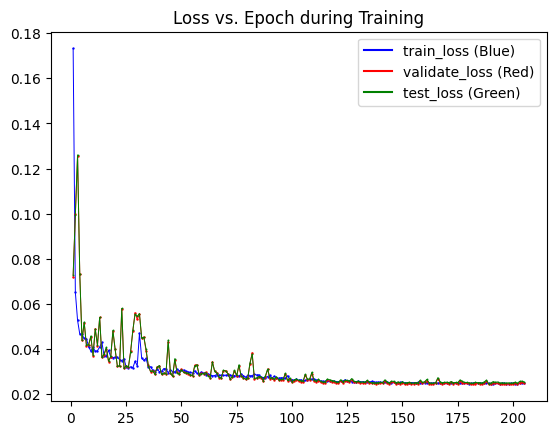

Epoch 205, training loss(MAE)=0.0248, validating loss(MAE)=0.0248, testing loss(MAE)=0.0255, lr=9.77e-06
Epoch 206, training loss(MAE)=0.0249, validating loss(MAE)=0.0248, testing loss(MAE)=0.0253, lr=9.77e-06


KeyboardInterrupt: 

In [5]:
epochs = args["epochs"]


for epoch in range(1, epochs + 1):

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    progress_msg = "Epoch " + str(epoch)
    progress_msg += ", training loss(MAE)=" + str(round(train_loss, 4))
    progress_msg += ", validating loss(MAE)=" + str(round(val_loss, 4))
    progress_msg += ", testing loss(MAE)=" + str(round(test_loss, 4))
    progress_msg += ", lr=" + str(round(current_lr, 8))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    print(progress_msg)
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=10)
    

In [8]:
def save_model_GCN(model, res_path,model_filename="model.pt"):
    model_filename = osp.join(res_path, model_filename)
    torch.save(model, model_filename)

MAE loss of formation energy is:  0.24537140130996704


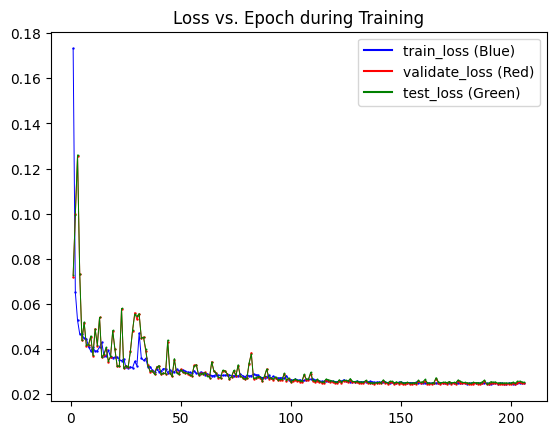

MAE=  0.24537138850598741


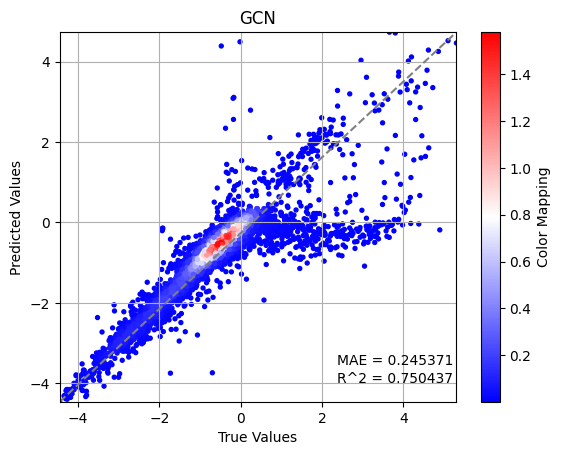

In [9]:
result_path = createResultFolder()
save_hyper_parameter(args, result_path)
save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

# Reverse normalization of test_out and y
min, max = get_data_scale(args)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print("MAE loss of formation energy is: ", loss.item())

# save results
plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
save_regression_result(test_out, test_y, result_path)
plot_regression_result("GCN", result_path, plotfilename="regression_figure.jpeg")

# save model
save_model_GCN(model,result_path)